# PCLab#3 - Group 1 - Johannes, Petter, and Oskar

Big picture context
- You’ve just been hired by a sophisticated hedge-fund
- The hedge-fund manager is interested in Twitter’s predictive power
- He asks you to perform sentiment analysis on a sample of recent financial tweets...
- ... and to build a firm-level measure of media attention: that may be a great factor idea !

Packages you may need
- Among others: wordcloud, nltk.stem, nltk.corpus, nltk.tokenize, gensim, tensorflow, string.punctuation, sklearn, etc.

In [1]:
import pandas as pd
import numpy as np

## Task #1: Basic manipulation and descriptive statistics
- Import the Data_PCLab3_Twitter_Stock_Sentiment.csv data and describe the sample (data available on BBoard)
- How many tweets, how many words per tweets, distribution of number of words per tweets, average sentiment, etc.

In [62]:
tweets = pd.read_csv('./data/Data_PCLab3_Twitter_Stock_Sentiment.csv')
stocks = pd.read_csv('./data/Data_PCLab1_Stock.csv',  index_col=0)


In [69]:
# Total number of tweets
total_tweets = len(tweets)
# Number of words per tweet
tweets['word_count'] = tweets['Text'].apply(lambda x: len(x.split()))
# Descriptive statistics for the number of words per tweet
word_stats = tweets['word_count'].describe()
# Average sentiment
average_sentiment = tweets['Sentiment'].mean()
# Output description
print(f"Total number of tweets: {total_tweets}")
print(f"Word count statistics per tweet:\n{word_stats}")
print(f"Average sentiment: {average_sentiment}")


Total number of tweets: 5791
Word count statistics per tweet:
count    5791.000000
mean       14.008807
std         6.595945
min         2.000000
25%         9.000000
50%        14.000000
75%        19.000000
max        32.000000
Name: word_count, dtype: float64
Average sentiment: 0.6363322396822656


## Task #2 : Cleaning and visualization
- Usual cleaning steps: remove punctuation, stopwords, short words, etc.
- Try your cleaning on this sentence: $I love AI & Machine learning applied to Finance...!! ;)
- Plot a word cloud for text with positive and negative sentiment separately • What is the number of unique words ?

In [70]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download stopwords and punkt tokenizer if needed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johannesmuller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johannesmuller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johannesmuller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [71]:

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Expanded tickers dictionary with variations for each stock
tickers_dict = {
    "AAPL": ["AAPL", "AAP", "Apple"],
    "BA": ["BA", "Boeing"],
    "T": ["T", "AT&T"],
    "MGM": ["MGM"],
    "AMZN": ["AMZN", "Amazon", "Bezoz", "Jeff"],
    "IBM": ["IBM"],
    "TSLA": ["TSLA", "Tesla", "Elon", "Musk"],
    "GOOG": ["GOOG", "Google"],
    "sp500": ["sp500", "S&P500"]
}


# Function to clean text and detect stock tickers
def clean_text(text, tickers_dict):
    # Remove punctuation, but keep decimal points between numbers
    text = re.sub(r'(?<!\d)[.,;:!?](?!\d)', '', text)
    
    # Tokenize the text
    words = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize (keeping short but important words like "i")
    clean_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words or len(word) == 1]
    
    # Join the clean words into a single string
    cleaned_text = " ".join(clean_words)
    
    # Check if any ticker symbols or variations are present in the text
    tickers_in_text = {}
    for ticker, variations in tickers_dict.items():
        tickers_in_text[ticker] = any(re.search(r'\b' + re.escape(variation.lower()) + r'\b', cleaned_text) for variation in variations)
    
    # Convert True/False to 1/0
    tickers_in_text = {k: 1 if v else 0 for k, v in tickers_in_text.items()}
    
    return cleaned_text, tickers_in_text

# Apply the cleaning function to all tweets and store the ticker presence as new boolean columns
def process_tweets(row, tickers_dict):
    cleaned_text, tickers_in_text = clean_text(row['Text'], tickers_dict)
    # Add cleaned text back to the row
    row['cleaned_text'] = cleaned_text
    # Add ticker presence as new columns
    for ticker, present in tickers_in_text.items():
        row[f'{ticker}_present'] = present
    return row

# Apply to tweets dataframe
tweets = tweets.apply(lambda row: process_tweets(row, tickers_dict), axis=1)

# Display the updated tweets dataframe with the new ticker columns
tweets.head()


,Text,Sentiment,BERT_Sentiment,FinBERT_Sentiment,word_count,cleaned_text,AAPL_present,BA_present,T_present,MGM_present,AMZN_present,IBM_present,TSLA_present,GOOG_present,sp500_present
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,0,2,20,kicker watchlist xide tit soq pnk cpw bpz aj t...,0,0,0,0,0,0,0,0,0
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,1,2,16,user aap movie 55 % return fea/geed indicator ...,1,0,0,0,0,0,0,0,0
2,user I'd be afraid to short AMZN - they are lo...,1,0,2,18,user i 'd afraid short amzn - looking like a n...,0,0,0,0,1,0,0,0,0
3,MNTA Over 12.00,1,0,2,3,mnta 12.00,0,0,0,0,0,0,0,0,0
4,OI Over 21.37,1,0,2,3,oi 21.37,0,0,0,0,0,0,0,0,0


In [72]:
tweets.describe()

,Sentiment,BERT_Sentiment,FinBERT_Sentiment,word_count,AAPL_present,BA_present,T_present,MGM_present,AMZN_present,IBM_present,TSLA_present,GOOG_present,sp500_present
count,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.0
mean,0.636332,0.249352,1.453808,14.008807,0.159731,0.002072,0.037990,0.002072,0.020204,0.003626,0.000691,0.034709,0.0
std,0.481096,0.432676,0.770505,6.595945,0.366388,0.045478,0.191189,0.045478,0.140709,0.060115,0.026275,0.183058,0.0
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.000000,2.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,2.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [8]:
# Example usage of the function with a test sentence
sample_sentence = "$I love AI & Machine learning applied to Finance...!! ;) Musk"
cleaned_sentence, tickers_present = clean_text(sample_sentence, tickers_dict)

print("Cleaned Sentence: ", cleaned_sentence)
print("Tickers Present: ", tickers_present)


Cleaned Sentence:  $ i love ai & machine learning applied finance ) musk
Tickers Present:  {'AAPL': 0, 'BA': 0, 'T': 0, 'MGM': 0, 'AMZN': 0, 'IBM': 0, 'TSLA': 1, 'GOOG': 0, 'sp500': 0}


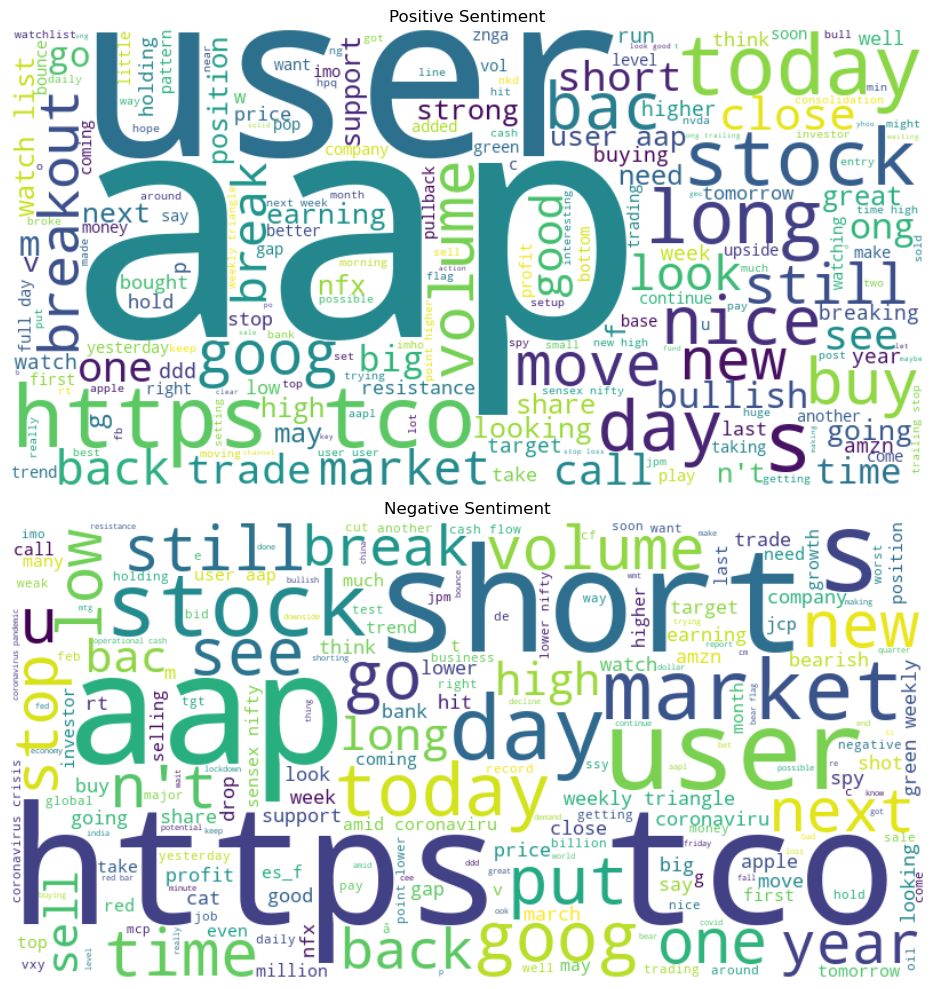

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split data by sentiment
positive_tweets = " ".join(tweets[tweets['Sentiment'] == 1]['cleaned_text'])
negative_tweets = " ".join(tweets[tweets['Sentiment'] == 0]['cleaned_text'])

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

# Plot word clouds
plt.figure(figsize=(10, 10))

# Positive sentiment word cloud
plt.subplot(2, 1, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

# Negative sentiment word cloud
plt.subplot(2,1, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Join all cleaned tweets into one large string
all_words = " ".join(tweets['cleaned_text'])
all_cleaned_words=all_words.translate(str.maketrans('', '', string.punctuation))
# Tokenize the words
unique_words = set(all_cleaned_words.split())
# Number of unique words
num_unique_words = len(unique_words)
print(f"Number of unique words: {num_unique_words}")

Number of unique words: 10884


## Task #3 : Sentment analysis
If any of those steps are not crystal clear, please tell me now (or shoot me an email soon after the class)
- More usual steps: Tokenizing the text and padding
    - Tokenize: vectorize text corpus, transform text into numbers
    - Padding: make all sentences the same lenght (fill with 0 short sentences)
- Split the sample in a train / test dataset (test = 10% of the total sample)
- Train model of your choice (RNN, LTSM, etc.) to predict the sentiment (1 or 0) on the test sample (you could use embedding layer to reduce the dimension of the problem)
- Plot the confusion matrix and compute the accuracy score (e.g., with sklearn function accuracy)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the maximum number of words to consider and the max tweet length
MAX_WORDS = 10000  # Use the top 10,000 words in the vocabulary
MAX_SEQUENCE_LENGTH = 50  # Pad all sentences to length of 50

# Tokenize the text corpus
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(tweets['cleaned_text'])  # Fit tokenizer on cleaned text

# Convert text to sequences of numbers
sequences = tokenizer.texts_to_sequences(tweets['cleaned_text'])

# Pad sequences to make all sentences the same length
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# The labels (sentiment)
y = tweets['Sentiment'].values


In [17]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def train_logistic_regression(X_train, y_train):
    # Define parameter grid for tuning
    param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
    
    # Initialize logistic regression model
    log_reg = LogisticRegression(random_state=42)
    
    # Grid search for the best parameters
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    return best_model


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

def train_rnn_model(X_train, y_train, max_words=MAX_WORDS, embedding_dim=50):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)
    
    return model


In [23]:
from tensorflow.keras.layers import LSTM

def train_lstm_model(X_train, y_train, max_words=MAX_WORDS, embedding_dim=50):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)
    
    return model


In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def train_xgboost(X_train, y_train):
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    
    # Grid search for the best parameters
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    return best_model

In [ ]:
# Example of using the train 
log_reg_model = train_logistic_regression(X_train, y_train)

rnn_model = train_rnn_model(X_train, y_train)

lstm_model = train_lstm_model(X_train, y_train)

xgb_model = train_xgboost(X_train, y_train)


In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name):
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # If using Keras models, convert predictions to binary values (0 or 1)
    if isinstance(model, Sequential):
        y_pred = (y_pred > 0.5).astype(int).reshape(-1)
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix for {model_name} (accuracy {accuracy:.4f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return 

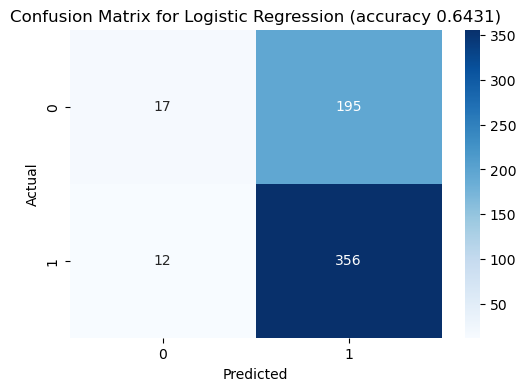

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


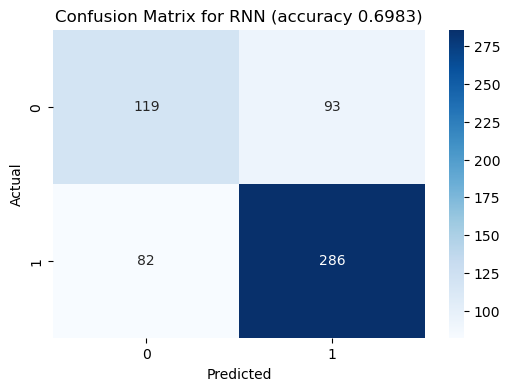

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


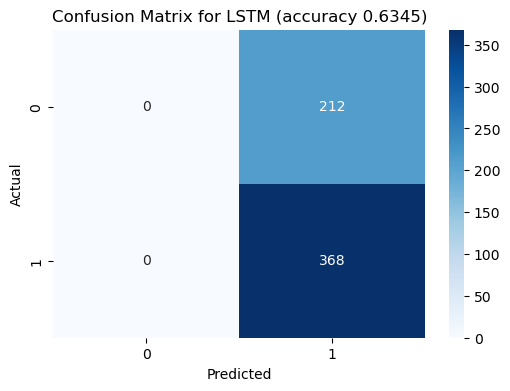

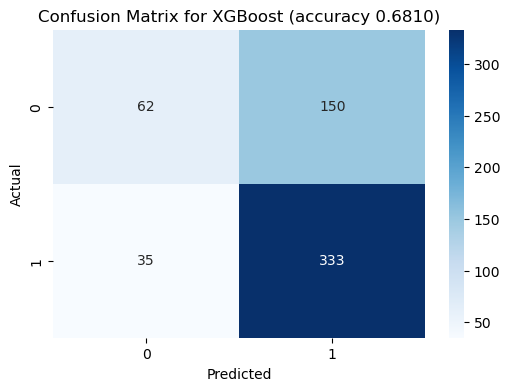

In [59]:
evaluate_model(log_reg_model, X_test, y_test, "Logistic Regression")

evaluate_model(rnn_model, X_test, y_test, "RNN")

evaluate_model(lstm_model, X_test, y_test, "LSTM")

evaluate_model(xgb_model, X_test, y_test, "XGBoost")


## Task #4 : Sentment analysis - Optional
- Use transformers (BERT from Huggingface) to perform another sentiment analysis and compare to the sentiment value in the data
    - Use pipeline: from transformers import pipeline
    - Use the already created library: text-classification or sentiment-analysis
- What is the performance of the algorithm on financial tweets ? I.e., how does BERT classifies the Tweets compared to the original classification you have ?
- Hint: check the Huggingface website
- To go further: check FinBERT

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                                   Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

      BERT_Sentiment  
0                  0  
1                  1  
2                  0  
3                  0  
4                  0  
...              ... 

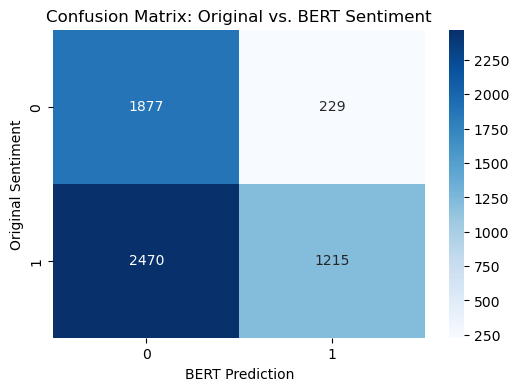

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.89      0.58      2106
           1       0.84      0.33      0.47      3685

    accuracy                           0.53      5791
   macro avg       0.64      0.61      0.53      5791
weighted avg       0.69      0.53      0.51      5791



In [65]:
# Install the transformers library if needed
# !pip install transformers

from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Load the sentiment analysis pipeline from Huggingface (BERT-based)
sentiment_pipeline = pipeline("sentiment-analysis")

# Sample Data (replace this with your actual tweets DataFrame)

# Applying BERT sentiment analysis to each tweet
def get_bert_sentiment(tweet):
    result = sentiment_pipeline(tweet[:512])  # Truncate tweet to 512 tokens to avoid overflow
    label = result[0]['label']
    if label == 'POSITIVE':
        return 1
    elif label == 'NEGATIVE':
        return 0
    else:
        return 2  # NEUTRAL (if applicable, depends on the model)

# Apply BERT sentiment analysis to each tweet and store the result
tweets['BERT_Sentiment'] = tweets['Text'].apply(get_bert_sentiment)

# Comparing BERT sentiment with the original sentiment labels
print(tweets[['Text', 'Sentiment', 'BERT_Sentiment']])

# Calculate accuracy
accuracy = accuracy_score(tweets['Sentiment'], tweets['BERT_Sentiment'])
print(f"Accuracy of BERT sentiment analysis: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(tweets['Sentiment'], tweets['BERT_Sentiment'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix: Original vs. BERT Sentiment")
plt.xlabel("BERT Prediction")
plt.ylabel("Original Sentiment")
plt.show()

# Detailed classification report
print("Classification Report:\n", classification_report(tweets['Sentiment'], tweets['BERT_Sentiment']))



In [66]:
# To use FinBERT for financial sentiment analysis, use the following:
finbert_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Apply FinBERT sentiment analysis
def get_finbert_sentiment(tweet):
    result = finbert_pipeline(tweet[:512])  # Truncate tweet to 512 tokens
    label = result[0]['label']
    if label == 'positive':
        return 1
    elif label == 'negative':
        return 0
    else:
        return 2  # Neutral (if FinBERT provides neutral sentiment)
    
# Use FinBERT for sentiment analysis on each tweet
tweets['FinBERT_Sentiment'] = tweets['Text'].apply(get_finbert_sentiment)

# Compare with original sentiments
print(tweets[['Text', 'Sentiment', 'FinBERT_Sentiment']])


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                                   Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

      FinBERT_Sentiment  
0                     2  
1                     2  
2                     2  
3                     2  
4                     2  
...

Accuracy of BERT sentiment analysis: 0.2934


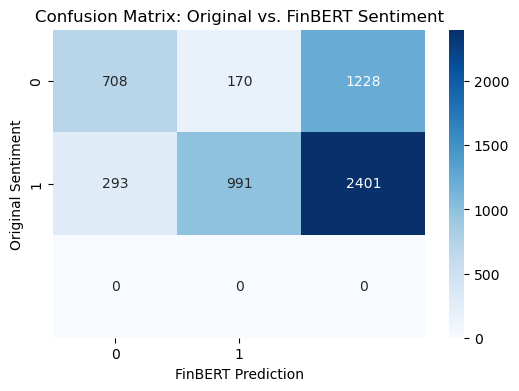

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.34      0.46      2106
           1       0.85      0.27      0.41      3685
           2       0.00      0.00      0.00         0

    accuracy                           0.29      5791
   macro avg       0.52      0.20      0.29      5791
weighted avg       0.80      0.29      0.43      5791



/Users/johannesmuller/miniconda3/envs/Mllab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johannesmuller/miniconda3/envs/Mllab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johannesmuller/miniconda3/envs/Mllab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [67]:
# Calculate accuracy
accuracy = accuracy_score(tweets['Sentiment'], tweets['FinBERT_Sentiment'])
print(f"Accuracy of BERT sentiment analysis: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(tweets['Sentiment'], tweets['FinBERT_Sentiment'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix: Original vs. FinBERT Sentiment")
plt.xlabel("FinBERT Prediction")
plt.ylabel("Original Sentiment")
plt.show()

# Detailed classification report
print("Classification Report:\n", classification_report(tweets['Sentiment'], tweets['FinBERT_Sentiment']))


## Task #5 : Measuring media attention
- Use the list of tickers gathered during last PC Lab (see the web-scrapping part) to compute the number of tweets about each stock
    - e.g., AAPL: 36 tweets, 12 negative, 24 positive
- Rank the stocks by their amount of total media attention, positive and negative media attention
- Optional: Using the stock prices data on our 8 stocks (or more from the web-scrapping task), do you see a correlation between media attention and excess return ?
- If yes, could Twitter attention is likely to be a good factor ?

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Assuming 'tweets' is your DataFrame containing sentiment columns and company presence columns
companies = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']

# Creating an empty dictionary to store results
company_stats = {}

for company in companies:
    company_col = f"{company}_present"
    
    # Calculate total tweets, positive, and negative for normal sentiment
    total_tweets = tweets[company_col].sum()
    positive_tweets = tweets[tweets[company_col] == 1][tweets['Sentiment'] == 1].shape[0]
    negative_tweets = tweets[tweets[company_col] == 1][tweets['Sentiment'] == 0].shape[0]
    
    # Calculate BERT sentiment
    bert_positive = tweets[tweets[company_col] == 1][tweets['BERT_Sentiment'] == 1].shape[0]
    bert_negative = tweets[tweets[company_col] == 1][tweets['BERT_Sentiment'] == 0].shape[0]
    
    # Calculate FinBERT sentiment
    finbert_positive = tweets[tweets[company_col] == 1][tweets['FinBERT_Sentiment'] == 1].shape[0]
    finbert_negative = tweets[tweets[company_col] == 1][tweets['FinBERT_Sentiment'] == 0].shape[0]
    
    # Store all the stats in the dictionary
    company_stats[company] = {
        'Total_Tweets': total_tweets,
        'Positive_Normal': positive_tweets,
        'Negative_Normal': negative_tweets,
        'Positive_BERT': bert_positive,
        'Negative_BERT': bert_negative,
        'Positive_FinBERT': finbert_positive,
        'Negative_FinBERT': finbert_negative
    }

# Convert the dictionary to a DataFrame for easier handling
company_df = pd.DataFrame(company_stats).T
company_df.reset_index(inplace=True)
company_df.rename(columns={'index': 'Company'}, inplace=True)

# Sort by total media attention
company_df = company_df.sort_values(by='Total_Tweets', ascending=False)

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_28046/558065003.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_28046/558065003.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_28046/558065003.py:20: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_28046/558065003.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_28046/558065003.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_28046/558065003.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/rl/glk77nxx70v4qglb24jl0byr

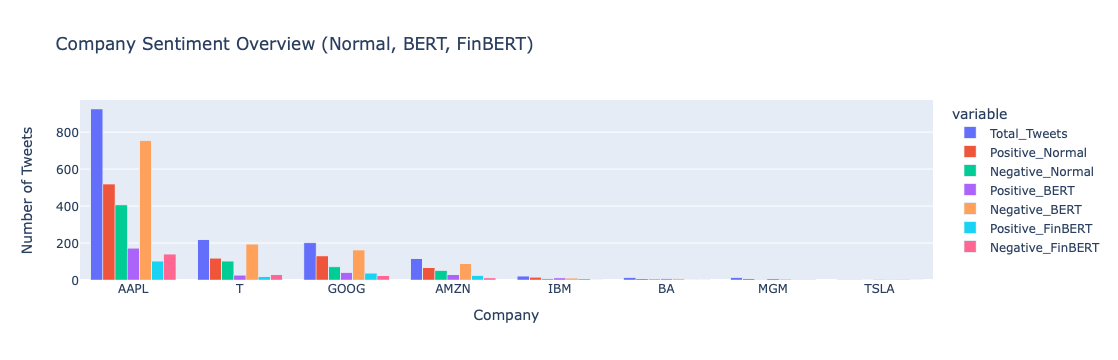

In [78]:
# Plot a concise bar chart for comparison
fig = px.bar(company_df, x='Company', y=['Total_Tweets','Positive_Normal', 'Negative_Normal', 'Positive_BERT', 'Negative_BERT', 'Positive_FinBERT', 'Negative_FinBERT'],
             title='Company Sentiment Overview (Normal, BERT, FinBERT)',
             labels={'value': 'Number of Tweets', 'Company': 'Company'},
             barmode='group')
fig.show()

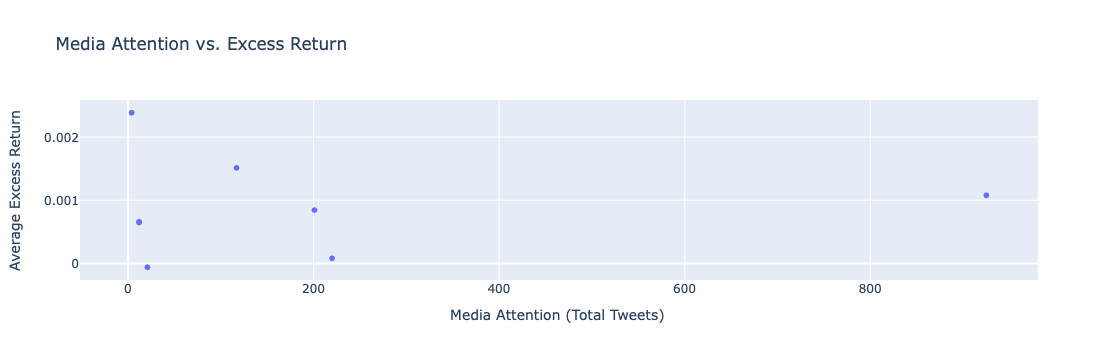

In [86]:
# Assuming 'stocks' contains the stock price data
stocks_list = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']
# Calculate daily returns for each stock
average_returns = stocks[stocks_list].pct_change().dropna().mean()
# Add the media attention (total number of tweets) for each company
media_attention = company_df.set_index('Company')['Total_Tweets']
# Create a DataFrame for returns and media attention
attention_return_df = pd.DataFrame({
    'Excess_Return': average_returns,
    'Media_Attention': media_attention
})
# Visualize correlation with scatter plot
fig = px.scatter(attention_return_df, x='Media_Attention', y='Excess_Return',
                 title='Media Attention vs. Excess Return',
                 labels={'Media_Attention': 'Media Attention (Total Tweets)', 'Excess_Return': 'Average Excess Return'})
fig.show()

In [87]:
tweets

,Text,Sentiment,BERT_Sentiment,FinBERT_Sentiment,word_count,cleaned_text,AAPL_present,BA_present,T_present,MGM_present,AMZN_present,IBM_present,TSLA_present,GOOG_present,sp500_present
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,0,2,20,kicker watchlist xide tit soq pnk cpw bpz aj t...,0,0,0,0,0,0,0,0,0
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,1,2,16,user aap movie 55 % return fea/geed indicator ...,1,0,0,0,0,0,0,0,0
2,user I'd be afraid to short AMZN - they are lo...,1,0,2,18,user i 'd afraid short amzn - looking like a n...,0,0,0,0,1,0,0,0,0
3,MNTA Over 12.00,1,0,2,3,mnta 12.00,0,0,0,0,0,0,0,0,0
4,OI Over 21.37,1,0,2,3,oi 21.37,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,0,0,19,industry body cii said # discoms likely suffer...,0,0,0,0,0,0,0,0,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,0,0,15,"# gold price slip r 46,000 # investor book pro...",0,0,0,0,0,0,0,0,0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,0,0,24,worker bajaj auto agreed a 10 % wage cut perio...,0,0,0,0,0,0,0,0,0
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,0,1,18,# sharemarket live sensex day ’ s high 600 poi...,0,0,0,0,0,0,0,0,0
